# Gaussian Mixture Model


:::{post} Sept 18, 2021
:tags: mixture model, pymc3.Categorical, pymc3.CategoricalGibbsMetropolis, pymc3.Dirichlet, pymc3.Metropolis, pymc3.Model, pymc3.Normal, pymc3.Potential, pymc3.Uniform
:category: intermediate
:::

In [1]:
!date
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")

Monday 20 September 2021 02:03:03 AM IST
Running on PyMC3 v3.11.2


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

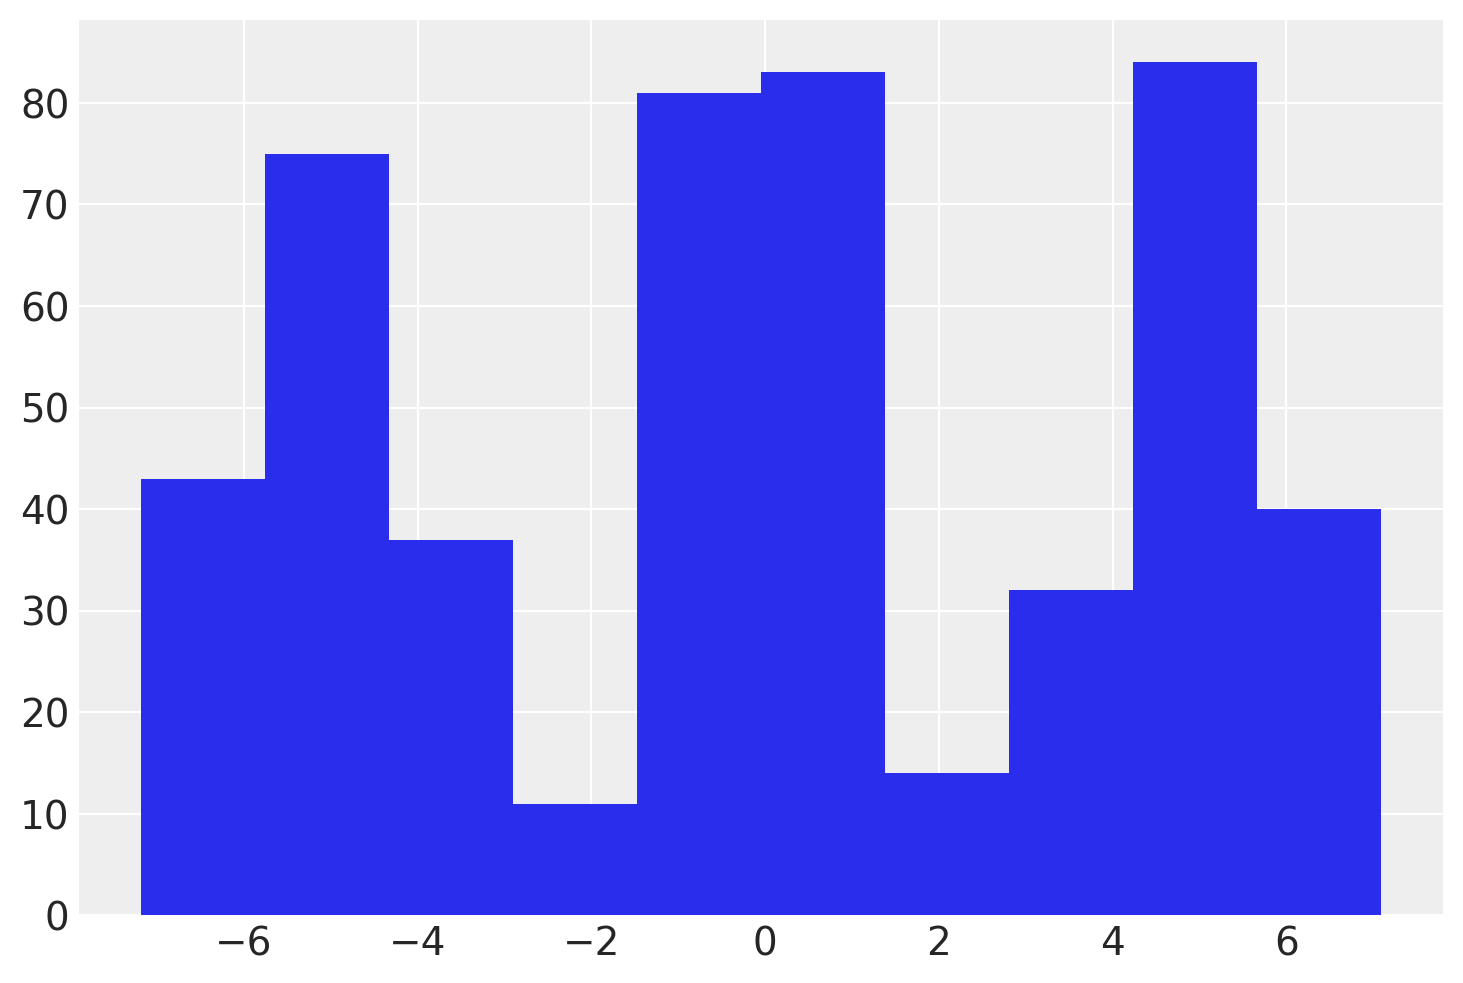

In [3]:
# simulate data from a known mixture distribution
k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = rng.integers(0, k, ndata)
data = centers[v] + rng.standard_normal(ndata)

plt.hist(data);

In [4]:
# setup model
model = pm.Model(coords={"cluster": np.arange(k), "obs_id": np.arange(ndata)})
with model:
    # cluster sizes
    p = pm.Dirichlet("p", a=np.array([1.0, 1.0, 1.0]), dims="cluster")
    # ensure all clusters have some points
    p_min_potential = pm.Potential("p_min_potential", tt.switch(tt.min(p) < 0.1, -np.inf, 0))

    # cluster centers
    means = pm.Normal("means", mu=[0, 0, 0], sigma=15, dims="cluster")
    # break symmetry
    order_means_potential = pm.Potential(
        "order_means_potential",
        tt.switch(means[1] - means[0] < 0, -np.inf, 0)
        + tt.switch(means[2] - means[1] < 0, -np.inf, 0),
    )

    # measurement error
    sd = pm.Uniform("sd", lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical("category", p=p, dims="obs_id")

    # likelihood for each observed value
    points = pm.Normal("obs", mu=means[category], sigma=sd, observed=data, dims="obs_id")

In [5]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category])
    trace = pm.sample(20000, step=[step1, step2], tune=5000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sd]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 3554 seconds.


0, dim: obs_id, 500 =? 500


/home/ada/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.


## Trace

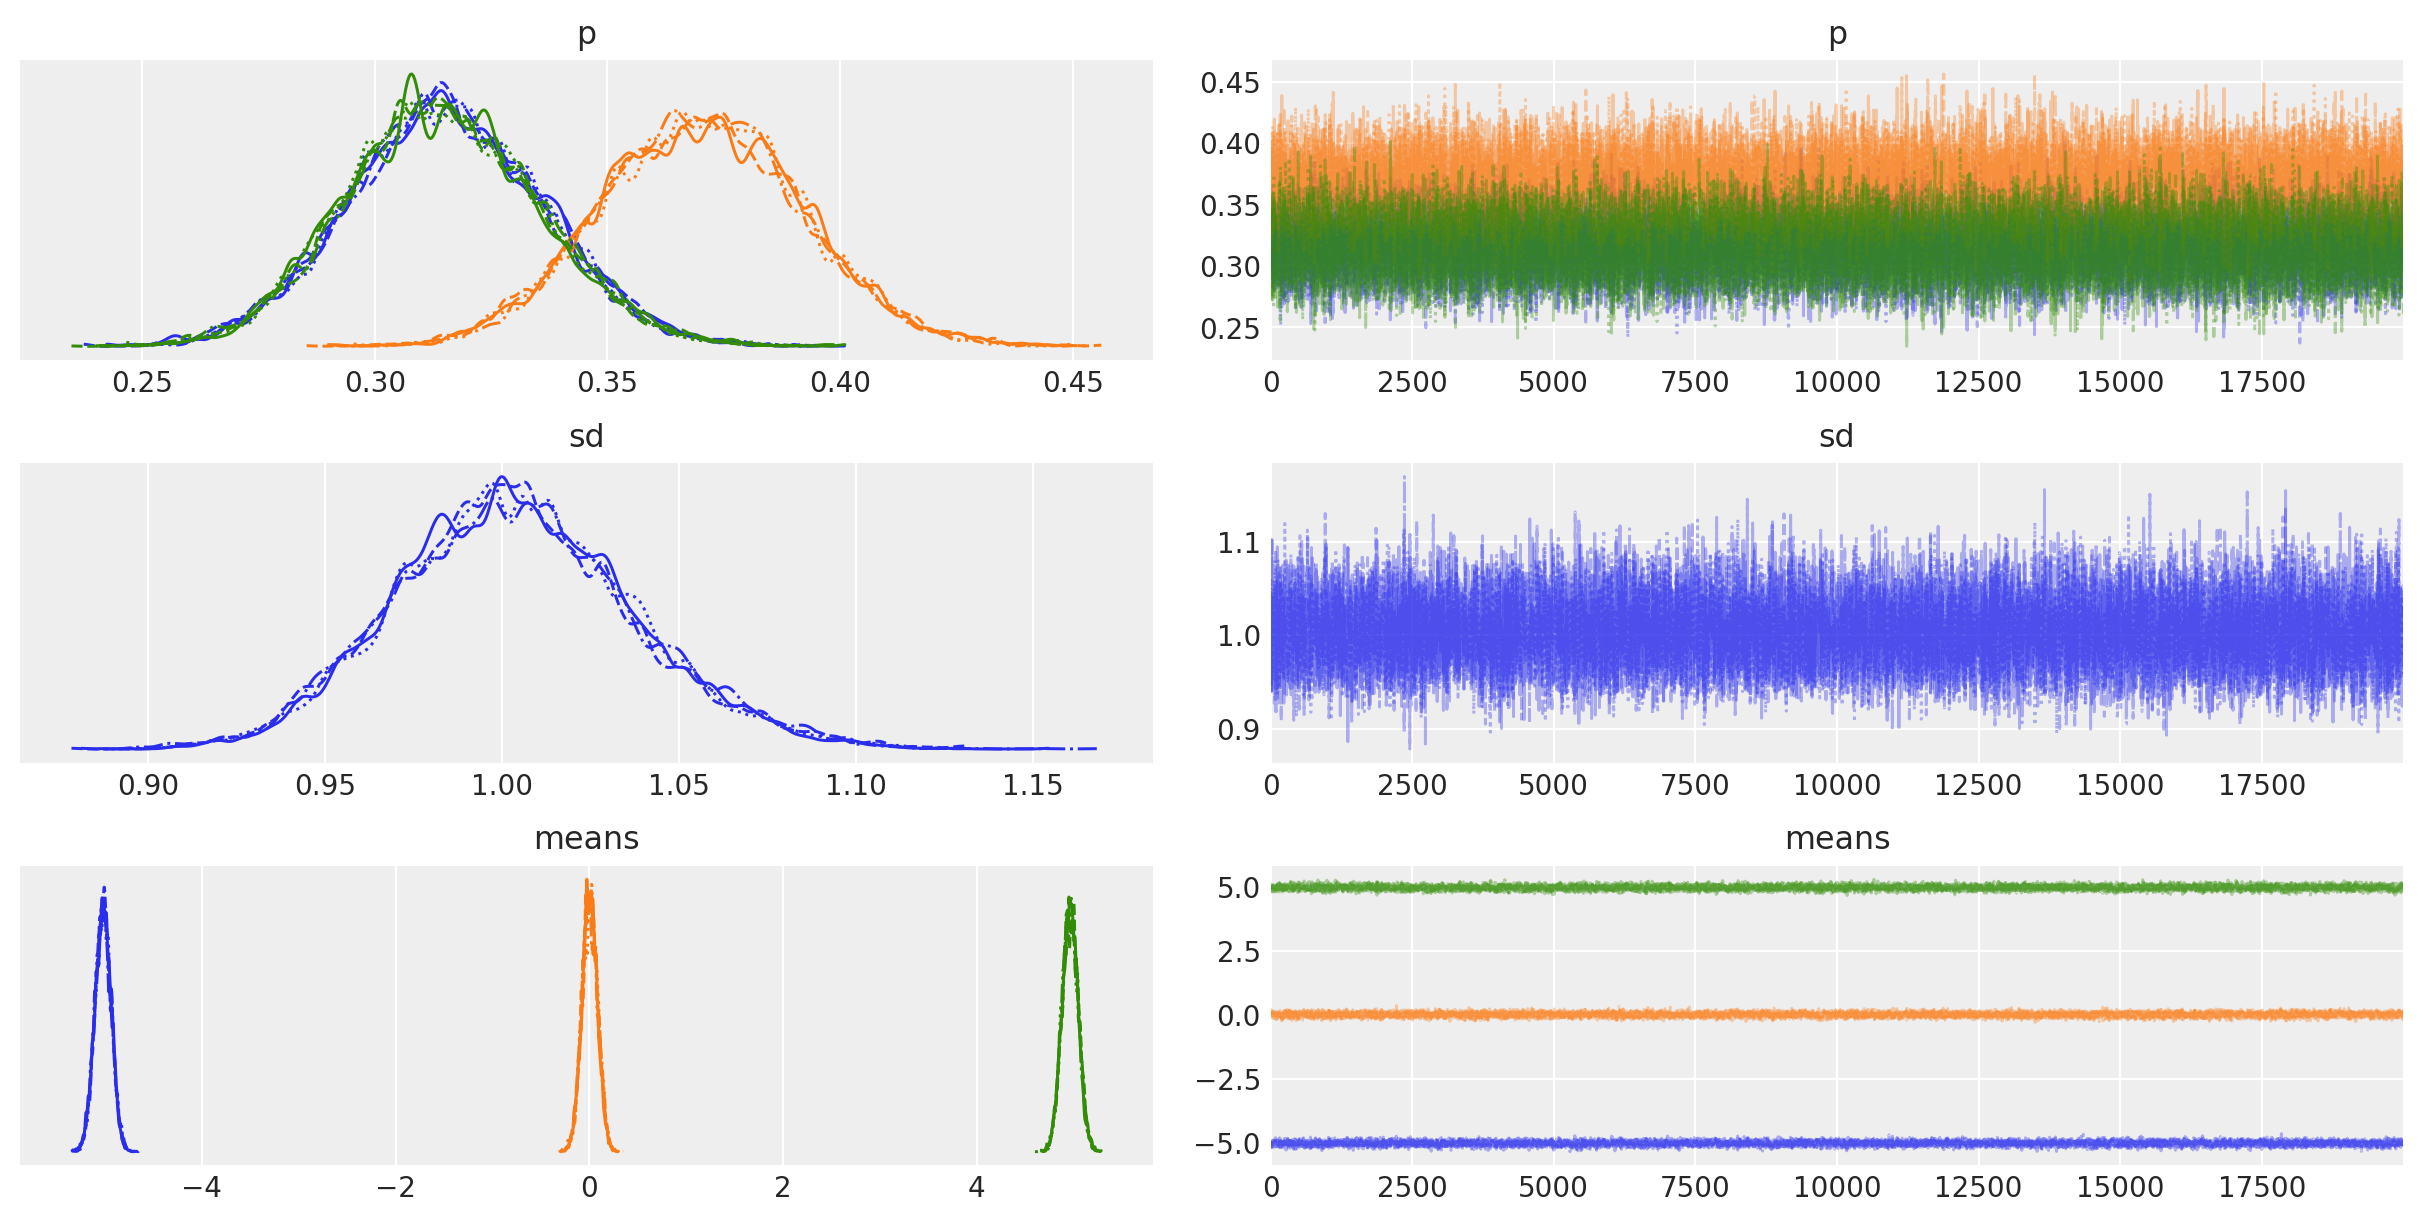

In [6]:
az.plot_trace(trace, var_names=["p", "sd", "means"]);

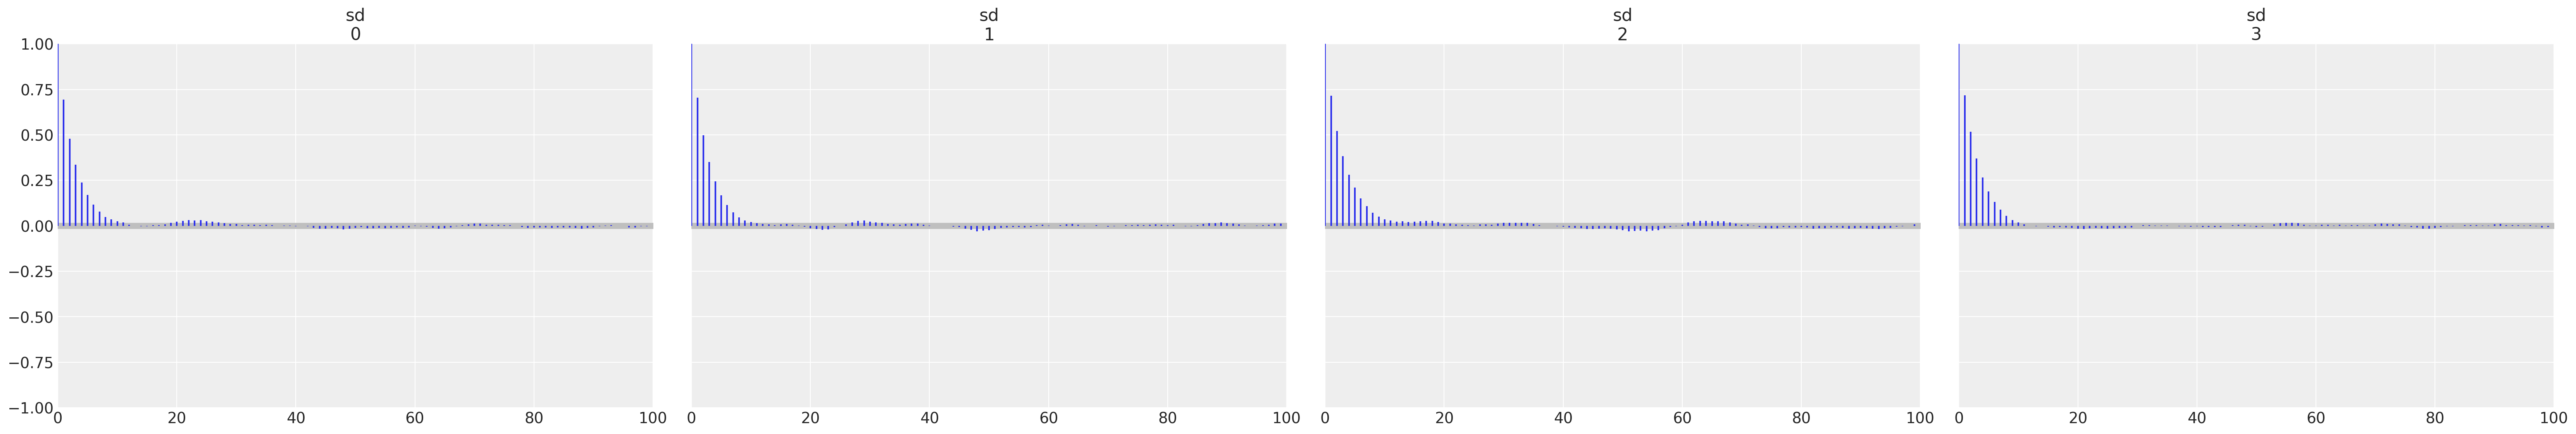

In [7]:
# I prefer autocorrelation plots for serious confirmation of MCMC convergence
az.plot_autocorr(trace, var_names=["sd"]);

## Sampling of cluster for individual data point

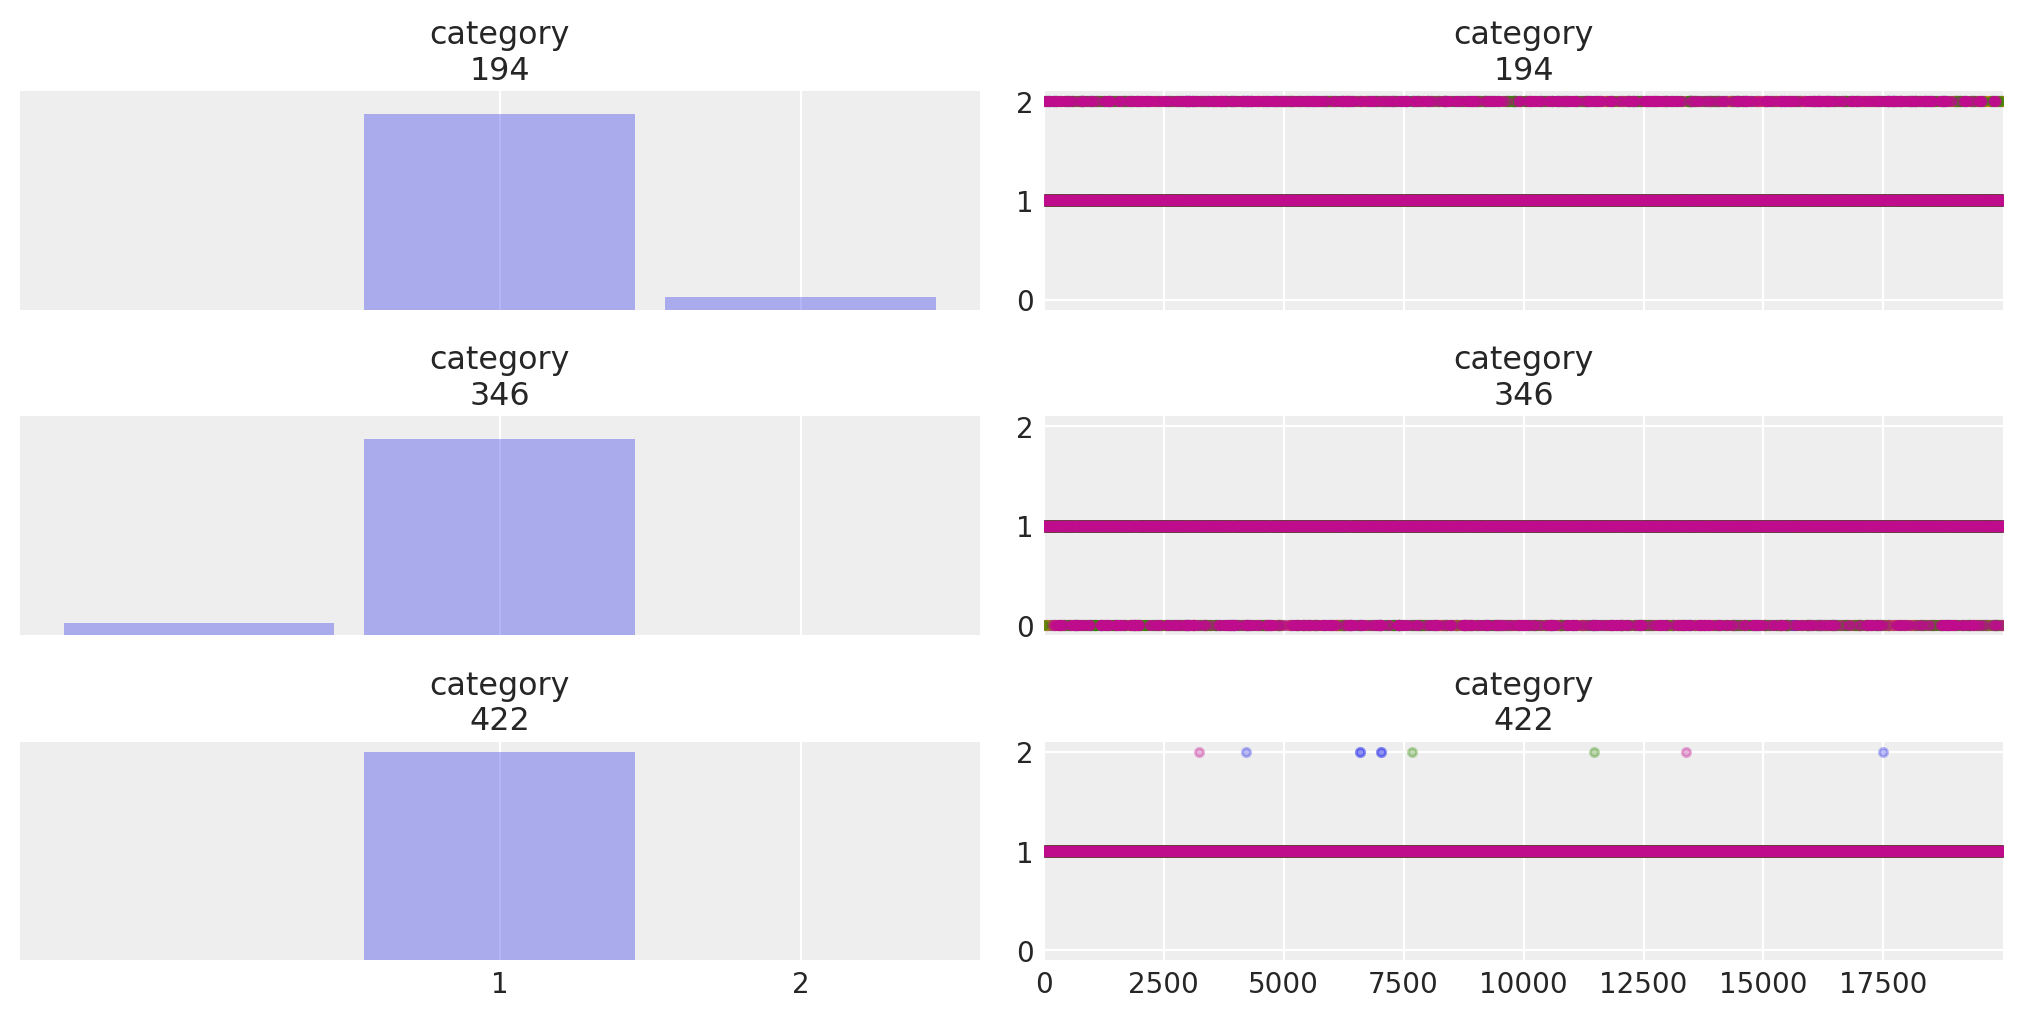

In [8]:
fig, axes = plt.subplots(3, 2, sharex="col", sharey="col", figsize=(10, 5))

az.plot_trace(
    trace,
    var_names="category",
    coords={"obs_id": [194, 346, 422]},
    compact=False,
    combined=True,
    trace_kwargs={"ls": "none", "marker": ".", "alpha": 0.3},
    axes=axes,
);

Original NB by Abe Flaxman, modified by Thomas Wiecki

## Watermark

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Mon Sep 20 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

xarray: 0.17.0

numpy     : 1.21.0
pymc3     : 3.11.2
pandas    : 1.2.1
theano    : 1.1.2
matplotlib: 3.3.4
arviz     : 0.11.2

Watermark: 2.2.0

